# Social infrastructure in LAC

**Objetive:** <br>
The following notebook runs all the social infrastructure analysis. <br><br>

Author: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br>
Created: March 20, 2023

## 1. Basics

In [1]:
%%capture
!pip install h3

In [2]:
%%capture
# Import modules 
from utils import * 
from h3 import geo_to_h3, h3_to_geo_boundary
from shapely.geometry import Polygon

## 2. Inputs

In [3]:
# Determine input values
data   = get_iadb()
codes  = data.isoalpha3.tolist()
groups = ["total_population","women","men","children_under_five","youth_15_24","elderly_60_plus","women_of_reproductive_age_15_49"]

## 3. Population

In [4]:
%%capture
# Inputs
group = "total_population"
code  = "BRA"

# Get population data 
file = get_population(data, code, group)

# Save data 
file.to_csv(f"../data/0-raw/population/{group}/{code}_{group}.csv.gz", compression = 'gzip')

## 4. Amenities

In [4]:
amenities = ['healthcare','financial']
for amenity in amenities:
    # Get infrastructure data
    infrastructure = get_amenity(amenity)
    
    # Save data 
    infrastructure.to_csv(f"../data/0-raw/infrastructure/{amenity}_facilities.csv")

## 4. Isochrones

In [ ]:
# Inputs
amenity = 'healthcare'
minute  = 30
profile = 'driving'
code    = "BRA"

# Get isochrones per amenity
isochrone = get_isochrones_country(code, amenity, minute, profile)

# Create one multipolygon
isochrones = isochrone.dissolve()

# Export isochrone 
isochrones.to_file(f"../data/1-isochrones/{amenity}/{code}-{profile}-{minute}.geojson", driver = "GeoJSON")

 # For financial services 
if amenity == "financial":
    for category in isochrone.amenity.unique():
        # Create one multipolygon
        isochrones = isochrone[isochrone.amenity == category]
        isochrones = isochrones.dissolve()
        
        # Export isochrone 
        isochrones.to_file(f"../data/1-isochrones/{amenity}/{category}/{code}-{profile}-{minute}.geojson", driver = "GeoJSON")

## 5. Coverage

### 5.1. Healthcare

In [ ]:
# Inputs
amenity = 'healthcare'
minute  = 30
profile = 'driving'
code    = "BRA"

# Create shapefile
adm2_, h3_ = get_coverage(code, amenity, profile, minute)

# Export isochrone 
adm2_.to_file(f"../data/2-coverage/{amenity}/adm2/{code}-{profile}-{minute}.geojson", driver = "GeoJSON")
h3_  .to_file(f"../data/2-coverage/{amenity}/h3/{code}-{profile}-{minute}.geojson"  , driver = "GeoJSON")

### 5.2. Financieros

In [ ]:
# Inputs
amenity    = 'financial'
subamenity = {"all":["","total"],"atm":["atm","atm"],"bank":["bank","bank"],"bureau_de_change":["bureau_de_change","bureau_de_change"]}
minute     = 30
profile    = 'driving'
code       = "BRA"

#for amenity_ in subamenity.keys():
for amenity_ in ["bank","bureau_de_change"]:
    # Labels 
    amenity_input  = f"{amenity}/{subamenity[amenity_][0]}"
    amenity_input  = re.sub("/$","",amenity_input)
    amenity_output = f"{amenity}/{subamenity[amenity_][1]}"

    # Create shapefile
    adm2_, h3_ = get_coverage(code, amenity_input, profile, minute)

    # Export isochrone
    adm2_.to_file(f"../data/2-coverage/{amenity_output}/adm2/{code}-{profile}-{minute}.geojson", driver = "GeoJSON")
    h3_  .to_file(f"../data/2-coverage/{amenity_output}/h3/{code}-{profile}-{minute}.geojson"  , driver = "GeoJSON")

### 5.3. Create regional shapefiles

In [6]:
# Shapefile ADMIN-2
file = f"Geospatial Basemaps/Cartographic Boundary Files/LAC-26/region/level-2/lac-level-2.shp"
path = scldatalake + file
shp  = gpd.read_file(path)

In [9]:
# Healthcare amenities
unit = "h3"
path = f"../data/2-coverage/healthcare/{unit}"
file = os.listdir(path)
shp_ = [gpd.read_file(f"{path}/{name}") for name in file]
lac  = gpd.pd.concat(shp_).pipe(gpd.GeoDataFrame)
lac.to_file(f"../data/2-coverage/healthcare/lac-{unit}-driving-30.geojson", driver = "GeoJSON")

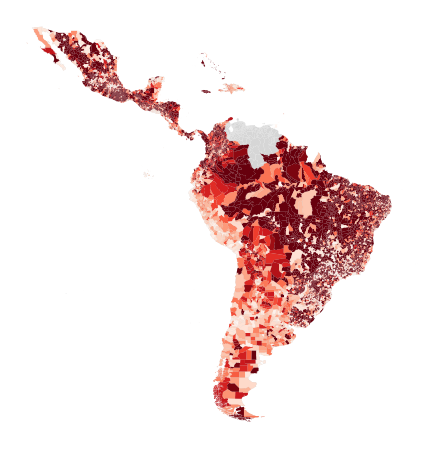

In [8]:
fig, ax = plt.subplots(1, figsize = (20,8))
shp.plot(ax = ax, color = "#D6D6D6")
lac.plot(ax = ax, cmap  = "Reds"   , column = "per_uncov")
ax.axis('off')
fig.show()

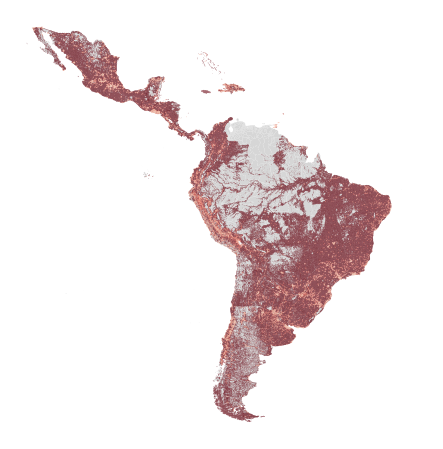

In [10]:
fig, ax = plt.subplots(1, figsize = (20,8))
shp.plot(ax = ax, color = "#D6D6D6")
lac.plot(ax = ax, cmap  = "Reds"   , column = "per_uncov")
ax.axis('off')
fig.show()

In [11]:
# Financial amenities
unit  = "adm2"
group = "total"
path  = f"../data/2-coverage/financial/{group}/{unit}"
file  = os.listdir(path)
shp_  = [gpd.read_file(f"{path}/{name}") for name in file]
lac   = gpd.pd.concat(shp_).pipe(gpd.GeoDataFrame)
lac.to_file(f"../data/2-coverage/financial/{group}/lac-{unit}-driving-30.geojson", driver = "GeoJSON")

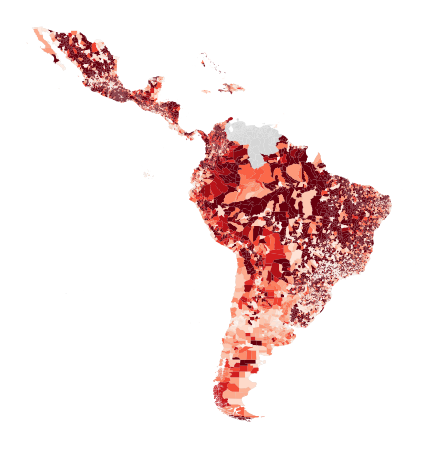

In [12]:
fig, ax = plt.subplots(1, figsize = (20,8))
shp.plot(ax = ax, color = "#D6D6D6")
lac.plot(ax = ax, cmap  = "Reds"   , column = "per_uncov")
ax.axis('off')
fig.show()

In [17]:
# Financial amenities
for group in ["total","atm","bank","bureau_de_change"]:
    unit  = "h3"
    path  = f"../data/2-coverage/financial/{group}/{unit}"
    file  = os.listdir(path)
    shp_  = [gpd.read_file(f"{path}/{name}") for name in file]
    lac   = gpd.pd.concat(shp_).pipe(gpd.GeoDataFrame)
    lac.to_file(f"../data/2-coverage/financial/{group}/lac-{unit}-driving-30.geojson", driver = "GeoJSON")